Final project

Group of at most 3 people

1. pick a data set and expalin what you want to predict
2. Clean the data, Scale it
3. Plot the data with PCA, and also with each features, and see if prediction would be possible
4. Remove correlated features
5. Test all the models and pick the best one (One of the same 5 train/test split - so you make 5 different X_train, X_test) and plot the results. Only use cross_validate to find
the best number of neighbors
6. Test the best model on another split with confusion matrix and plot, which features is important.
7. Train on the whole set with the best model and predict values you pick
8. Try an ensemble model and compare it to the best model
ensemble model - pick multiple models that predict something, and do the average/linear regression on those model's results

proj due december 1st

points for cleanliness

plots explaining dataset, how it looks, features, what you predict, clean it

find best mode, conf matrix

the more complex dataset, the more points its worth

same split, for cross validate

try to do a model we have not done

want boundary plot, feature importance

cares more about explanation than model or accuracy

remove nulls, if you can't pick the medians

convert yes/no strings to 0/1

know group and dataset before break

histograms of yes and no, boxplot, graphs of 1 feature vs another

predictions

In [141]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import random
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

This Jupyter notebook covers data on the 2000 most recent reviews for Delta Airlines from airlinequality.com. 

The dataset was collected on November 17th, 2023, but the code for the scraper used to collect the data was provided alongside this notebook.

In [38]:
df = pd.read_csv("reviews.csv")
df = df.drop(columns=["Unnamed: 0"])
df.describe()

,rating,seat_comfort,cabin_staff_service,food_and_beverages,inflight_entertainment,ground_service,wifi_and_connectivity,value_for_money,recommended,verified
count,1998.000000,1885.000000,1879.000000,1450.000000,1320.000000,1939.000000,1159.000000,1998.000000,1998.000000,1998.000000
mean,3.285786,2.485411,2.759979,2.487586,2.833333,2.195977,2.283865,2.097598,0.244244,0.679680
std,3.264797,1.436713,1.601841,1.466976,1.581099,1.569433,1.513785,1.487381,0.429746,0.466716
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,0.000000,1.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000


Initial analysis

In [39]:
for col in df.columns:
    print("Column name: " + col + " NAs: " + str(df[col].isna().sum()) + " Datatype: " + str(df[col].dtype))

Column name: rating NAs: 0 Datatype: int64
Column name: aircraft NAs: 1622 Datatype: object
Column name: type_of_traveller NAs: 0 Datatype: object
Column name: cabin_flown NAs: 0 Datatype: object
Column name: route NAs: 20 Datatype: object
Column name: date_flown NAs: 0 Datatype: object
Column name: seat_comfort NAs: 113 Datatype: float64
Column name: cabin_staff_service NAs: 119 Datatype: float64
Column name: food_and_beverages NAs: 548 Datatype: float64
Column name: inflight_entertainment NAs: 678 Datatype: float64
Column name: ground_service NAs: 59 Datatype: float64
Column name: wifi_and_connectivity NAs: 839 Datatype: float64
Column name: value_for_money NAs: 0 Datatype: float64
Column name: recommended NAs: 0 Datatype: int64
Column name: verified NAs: 0 Datatype: int64
Column name: review NAs: 0 Datatype: object


All the columns were on a 1-5 scale as they asked passengers to rate different aspects of their experience flying with Delta. However, the 'rating' column is on a scale of 1-10

(-0.5, 399.5, 199.5, -0.5)

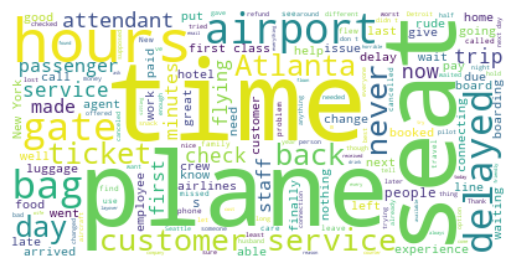

In [40]:
#wordcloud
text = " ".join(review for review in df.review)

stopwords = set(STOPWORDS)
stopwords.update(["flight", "Delta", "one", "told", "took", "said", "two", "make", "given", "minute",
                  "asked", "still", "way", "hour", "will", "really", "u", "got", "without", "say", "better", "take",
                  "overall", "much", "return", "fly", "us", "even", "go", "getting", "airline", "flights", "another"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.figure(figsize=[10,10])

We wanted to know how passengers described their Delta experience. We discovered that passengers commented on comfortability ("Seat") and timeliness most.

Text(0.5, 1.0, 'Correlation Matrix')

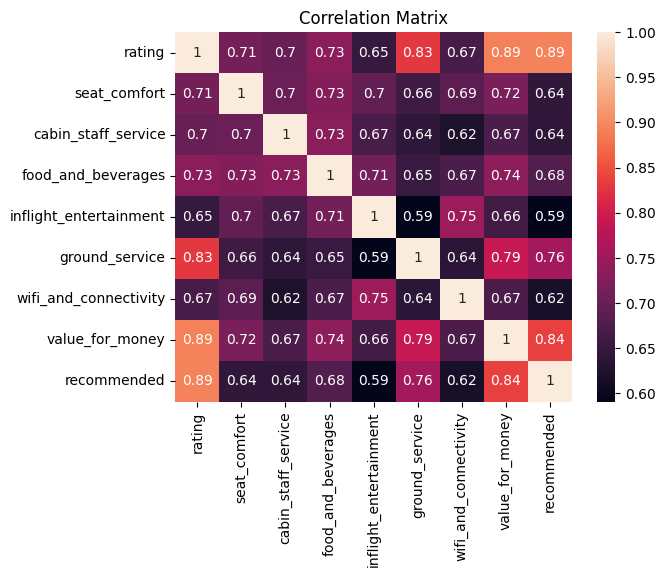

In [41]:
#correlation matrix
df_numerical = pd.concat([df["rating"], df[df.columns[6:14]]], axis=1)
corrmat = df_numerical.corr()

sns.heatmap(corrmat, annot=True)
plt.title("Correlation Matrix")

In [80]:
#drop nas
df_no_na = df_numerical.dropna()
#predict recommended
cols = df_no_na.columns[0:8]
X = df_no_na[cols]
y = df_no_na["recommended"]

Amount of rows with no NAs: 1018
PCA component weight:
[[ 0.68201288  0.2583285   0.28295311  0.26363575  0.27786971  0.29070003
   0.26119766  0.29768482]
 [-0.57232367  0.26792258  0.32417587  0.26312738  0.49649071 -0.13674664
   0.3809336  -0.12658598]]


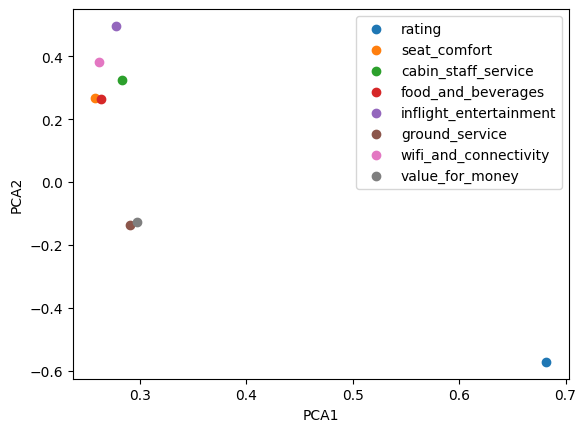

In [43]:
#pca for dimensionality reduction
pca = decomposition.PCA(n_components=2)
print("Amount of rows with no NAs: " + str(len(df_no_na)))
X_pca = pca.fit_transform(X)

weights = pca.components_
labels = X.columns.to_list()
print("PCA component weight:\n" + str(pca.components_))

for i in range(len(X.columns)):
    plt.scatter(weights[0,i],weights[1,i],label=labels[i])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()

Text(0, 0.5, 'PCA2')

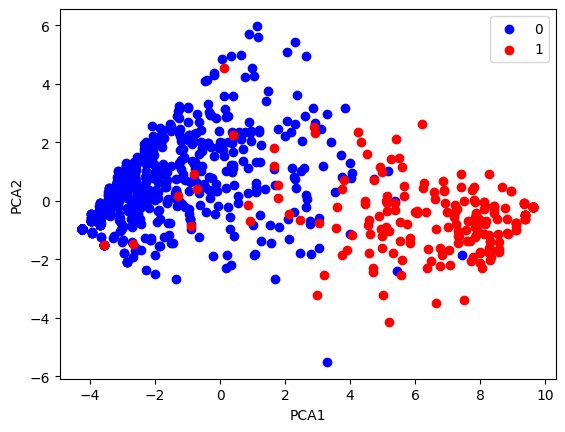

In [44]:
#plot data
cat_0_indexes=np.where(y==0)[0]
cat_1_indexes=np.where(y==1)[0]
plt.scatter(X_pca[cat_0_indexes,0],X_pca[cat_0_indexes,1],c='b',label="0")
plt.scatter(X_pca[cat_1_indexes,0],X_pca[cat_1_indexes,1],c='r',label="1")
plt.legend()
plt.xlabel('PCA1')
plt.ylabel('PCA2')

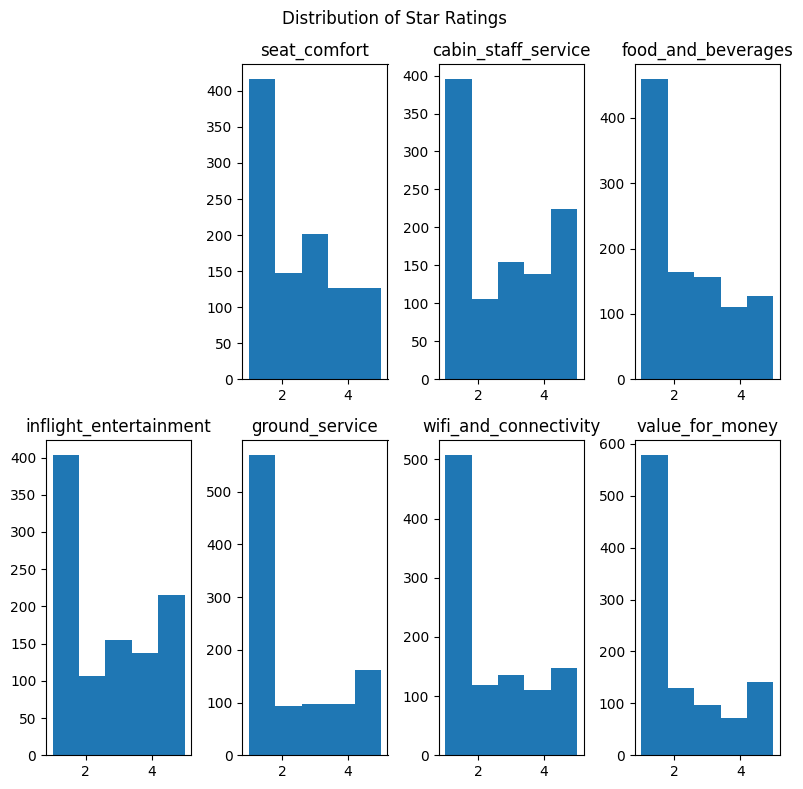

In [45]:
# Unique categories in each variable
col_names = X.columns

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(8, 8), sharex=False, sharey=False)

# Loop through each category combination and plot histogram
for i in range(1, len(col_names)):
    current = axes[i//4, i % 4]
    current.hist(X[col_names[i]], bins=5, alpha=1)
    current.set_title(col_names[i])

fig.suptitle("Distribution of Star Ratings")
axes[0, 0].remove()
# Adjust layout
plt.tight_layout()
plt.show()

final analysis: ground service and food and beverages were dropped

## Modelling

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
seed = random.seed(22)

### KNN

We need to find the best number of neighbours first and then evalute the model's accuracy 

In [47]:
# Split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)

# KNN
best_neighbors = None
best_score = 0

for n_neighbors in range(1, 11):
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_validate(knn_model, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(scores['test_score'])
    
    if mean_score > best_score:
        best_score = mean_score
        best_neighbors = n_neighbors

# Train the best KNN model
best_knn_model = KNeighborsClassifier(n_neighbors=best_neighbors)
best_knn_model.fit(X_train, y_train)

# Evaluate KNN
y_pred = best_knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy: {knn_accuracy:.4f}")

KNN Model Accuracy: 0.9657


### Neural Network

We need to first find the best hyperparameters for the model. This is done using grid search 

In [48]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)

# Define the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(40,),(20,),(64,),(128,), (40, 20)],
    'max_iter': [8,15, 50, 75, 100]
}

clf = MLPClassifier(solver="sgd",
                    random_state=1,
                    alpha=1e-4,
                    learning_rate_init=0.5,)

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=None)

grid_search.fit(X_train, y_train)

# Get the best model from the search
best_nn_clf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'hidden_layer_sizes': (64,), 'max_iter': 8}


Train the classifer using a the best parameters from the grid search then plot its accuracy

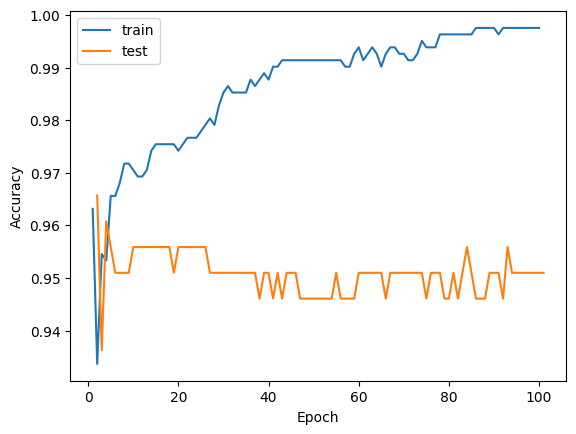

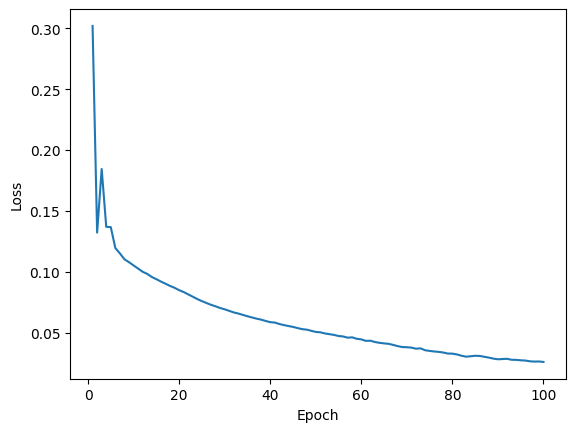

Neural Network: 0.9510


In [58]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

max = 8
layers = 64

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)

# Initialize the MLPClassifier
clf = MLPClassifier(
    hidden_layer_sizes=(layers),
    max_iter=max,
    alpha=1e-4,
    solver="sgd",
    verbose=0,
    random_state=1,
    learning_rate_init=0.5,
)

N = 100
s1=[]
s2=[]
l = []

for i in range(N):
    clf.partial_fit(X_train, y_train,classes=np.unique(y_train))
    s1.append(clf.score(X_train, y_train))
    s2.append(clf.score(X_test, y_test))
    l.append(clf.loss_)

# Plotting the accuracy for training and test sets
plt.figure(1)
plt.plot(np.arange(1,N+1),s1,label='train')
plt.plot(np.arange(1,N+1)+1,s2,label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss
plt.figure(2)
plt.plot(np.arange(1,N+1),l,label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the best model 
y_pred = clf.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)
print(f"Neural Network: {nn_accuracy:.4f}")

### Additional Models

In [50]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

# Evaluate Random Forest
y_pred = clf_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.9608


In [51]:
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Evaluate Logistic Regression
y_pred = logistic_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression: {logreg_accuracy:.4f}")

Logistic Regression:0.9657


In [52]:
# SVM
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Evaluate SVM
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f"SVM: {svm_accuracy:.4f}")

SVM: 0.9755


In [53]:
# Gradient Boosting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)
GBCmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
GBCmodel.fit(X_train, y_train)

# Evaluate Gradient Boosting 
y_pred = GBCmodel.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting: {gb_accuracy:.4f}")

Gradient Boosting: 0.9608


### Plotting the Accuracies

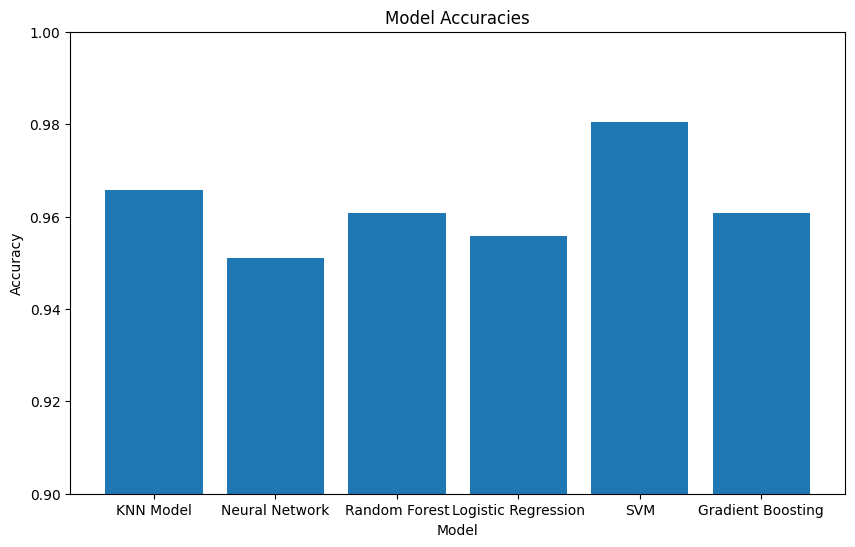

In [125]:
model_accuracies = {
    'KNN Model': knn_accuracy,
    'Neural Network': nn_accuracy,
    'Random Forest': rf_accuracy,
    'Logistic Regression': logreg_accuracy,
    'SVM': svm_accuracy,
    'Gradient Boosting':gb_accuracy,
}

# Extract model names and accuracies
models, accuracies = zip(*model_accuracies.items())

# And then
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0) 
plt.show()


The best model appears to be SVM with an accuracy of SVM: 0.9755 so we will select it as our model of choice

SVM test score: 0.9804


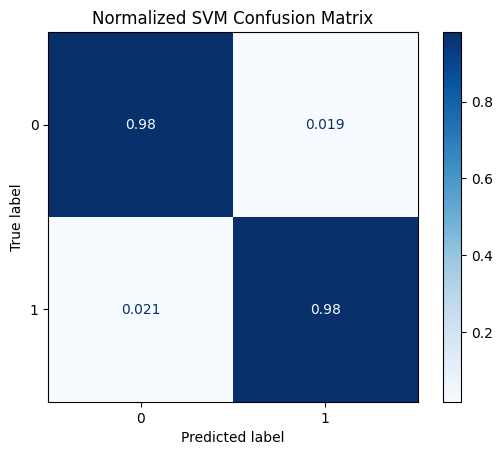

In [139]:
# SVM as the best model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=21)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Evaluate SVM
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f"SVM test score: {svm_accuracy:.4f}")

#Plot confusion matrix 
conf_matrix_rf = confusion_matrix(y_test, svm_model.predict(X_test))
disp_svm = ConfusionMatrixDisplay.from_estimator(
    svm_model,
    X_test,
    y_test,
    display_labels=svm_model.classes_,
    cmap=plt.cm.Blues,
    normalize='true',
)
disp_svm.ax_.set_title('Normalized SVM Confusion Matrix')
plt.show()

The confusion matrix shows that the model does a great job at accurately predicting 0's and 1's with a small percentage of type 1 and type 2 errors

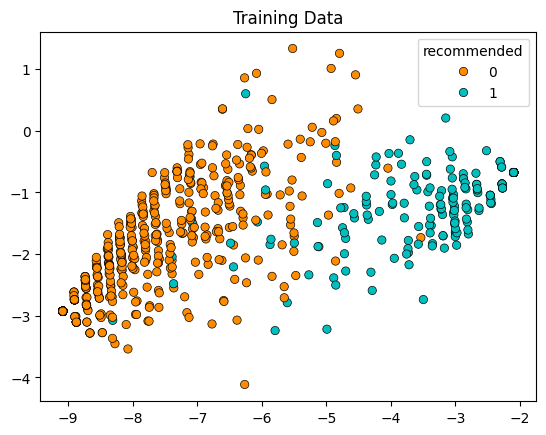

Train Score 0.9865
Test Score 0.9951


In [140]:
pca = PCA(n_components=2)
pca.fit(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

X2 = pca.transform(X_train)

sns.scatterplot(
    x=X2[:, 0],
    y=X2[:, 1],
    hue = y_train,
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.title('Training Data')
plt.show()

print("Train Score {:.4f}".format(clf.score(X_train,y_train)))
print("Test Score {:.4f}".format(clf.score(X_test,y_test)))



### Feature Importance

Now we will consider feature importance. For a linear SVM model, the coefficients of the hyperplane are interpreted as the feature importance

In [91]:
# pick the largest coefficient 
feature_importance = svm_model.coef_[0]
indices_desc = np.argsort(feature_importance)[::-1]
print(feature_importance)
print(cols[indices_desc[:2]])

[ 1.18386397 -0.09581117  0.40456496  0.0141991   0.05003851 -0.08675757
  0.1888647   0.69347545]
Index(['rating', 'value_for_money'], dtype='object')


According to the model, the most important features are ratings and whether the customer felt they had recieved the value for their money. This makes sense because people are more likely to recommend an airline they ranked highly, as well as one that is worth the preceived expense

### Prediction

Now given a random data points, what will the model predict?

In [156]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np

svm_model = SVC(kernel='linear')
svm_model.fit(X_scaled, y)

scaler = StandardScaler()
scaler.fit(X) 

data_point = np.random.randint(1, 11, size=(1, 8))
bad_data = np.array([[4, 3, 5, 2, 5, 3, 0, 5]])  
good_data = np.array([[9, 2, 5, 3, 4, 4, 3, 4]]) 

# Scale the new data points
scaled_data_point = scaler.transform(data_point)
scaled_bad_data = scaler.transform(bad_data)
scaled_good_data = scaler.transform(good_data)

# predictions
prediction = svm_model.predict(scaled_data_point)
bad_prediction = svm_model.predict(scaled_bad_data)
good_prediction = svm_model.predict(scaled_good_data)

print(data_point)
print("Prediction for data_point:", prediction)
print("Prediction for bad_data:", bad_prediction)
print("Prediction for good_data:", good_prediction)


[[ 6 10  6 10  1  7  7  3]]
Prediction for data_point: [1]
Prediction for bad_data: [0]
Prediction for good_data: [1]


Each test case appears to produce an accurate prediction, given the ratings in the sample data point 

### Ensemble

But how can we make this more accurate?

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Initialize individual models
knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
logistic_model = LogisticRegression(random_state=seed)
svm_model = SVC(kernel='linear', probability=True, random_state=seed)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed)
nn_model = MLPClassifier(hidden_layer_sizes=(layers), max_iter=max, alpha=1e-4, solver="sgd", verbose=0, random_state=1, learning_rate_init=0.5)

# Train individual models
knn_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
logistic_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)


# Create an ensemble of different models
ensemble = VotingClassifier(
    estimators=[
        ('knn', knn_model),
        ('rf', rf_model),
        ('logistic', logistic_model),
        ('svm', svm_model),
        ('gb', gb_model),
        ('nn', nn_model)
    ],
    voting='hard')  

# Train the ensemble on the entire dataset
ensemble.fit(X_scaled, y)

# Evaluate the ensemble
ensemble_accuracy = accuracy_score(y_test, ensemble.predict(X_test))
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")


Ensemble Accuracy: 0.9902


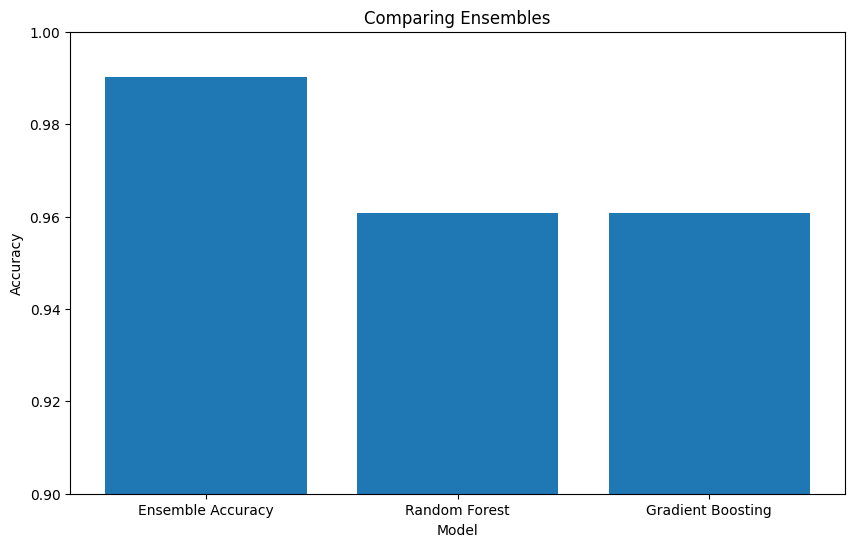

In [157]:
model_accuracies = {
    'Ensemble Accuracy': ensemble_accuracy,
    'Random Forest': rf_accuracy,
    'Gradient Boosting':gb_accuracy,
}

# Extract model names and accuracies
models, accuracies = zip(*model_accuracies.items())

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.title('Comparing Ensembles')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0) 
plt.show()


Our ensemble performed better when compared to the other ensembles model